<a href="https://colab.research.google.com/github/angelotc/FriedmanIsolationForest/blob/main/FriedmanIsoForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import model_selection 
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [103]:
# Helper functions

def add_y_as_feature(X,y):
    X['y1']=y
    return X

def contaminate_df(df1, df2, percentage):
    '''
    Assumes :
    - df1 and df2 have the same number of samples.
    - df1 is the dataset you will train on
    - df2 is the dataset with outliers
    Parameters:
    df1 (df) - dataframe to contaminate
    df2 (df) - dataframe that is contaminated (has noise)
    percentage (float) - Percentage in the form of a float (0,1) . It will add remove this percentage of rows from df1, and add this percentage of the contaminated rows from df2 into df1. 
    For example, if float = 0.05, it will remove the last 5% of the rows in df1, and add the first 5% of the rows from df2 into df1 and return that modified dataframe as the first dataframe.
    The second dataframe that it returns are the samples from df2 that were not added to df1.
    
    Returns:
    three dataframes:
    - modified df1 with contaminated samples
    - the samples from df2 that were not added to df1 (we will save this to use as a training set)
    - the actual outcomes of modified df1
    '''
    assert(len(df1) == len(df2)), "y1 needs to be the same length as y2"
    return df1[:int(len(df2)*(1-percentage))].append(df2[:int(len(df2)*percentage)]), pd.DataFrame([1]*int(len(y1)* (1 - percentage)) + [-1]*int(len(y1)*percentage), columns = ["is_outlier"]), df2[int(len(df2)*percentage):]


In [88]:
# Create synthetic dataset using make_friedman1. N = 100k

X1, y1 = make_friedman1(
    n_samples=1000, n_features = 5 , random_state=1)


# Create another synthetic dataset with noise.
X2, y2 = make_friedman1(
    n_samples=1000, n_features = 5, random_state=1, noise=20,)

y2 += 30

# Convert from numpy arrays to pandas dataframes
X1 = pd.DataFrame(X1, columns = ["x1", "x2", "x3", "x4", "x5"])
y1 = pd.DataFrame(y1, columns = ["y1"])
X2 = pd.DataFrame(X2, columns = ["x1", "x2", "x3", "x4", "x5"])
y2 = pd.DataFrame(y2, columns = ["y1"])

In [132]:
X1=False
y1=False
X2= False
y2=False

def f(y2_mean_slider,y2_noise):
  global X1, y1, X2, y2
  # Create synthetic dataset using make_friedman1. N = 100k
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(figsize=(10,4))
  X1, y1 = make_friedman1(
      n_samples=1000, n_features = 5 , random_state=1)


  # Create another synthetic dataset with noise.
  X2, y2 = make_friedman1(
      n_samples=1000, n_features = 5, random_state=1, noise=y2_noise )

  y2 += y2_mean_slider

  # Convert from numpy arrays to pandas dataframes
  X1 = pd.DataFrame(X1, columns = ["x1", "x2", "x3", "x4", "x5"])
  y1 = pd.DataFrame(y1, columns = ["y1"])
  X2 = pd.DataFrame(X2, columns = ["x1", "x2", "x3", "x4", "x5"])
  y2 = pd.DataFrame(y2, columns = ["y1"])
  import seaborn as sns
  sns.set()
  # n_bins = len(X)//100
  # We can set the number of bins with the `bins` kwarg

  sns.histplot(y1['y1'], bins = 'auto', stat='probability', color = 'blue', binwidth = 3, ax=ax)
  sns.histplot(y2['y1'], bins = 'auto', stat='probability', color = 'orange', binwidth = 3, ax=ax);
  
y2_mean_slider = widgets.FloatSlider(
    value=30,
    min=-100,
    max=100,
    step=1,
    description='y2 mean shift',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
  
)


y2_noise_slider = widgets.FloatSlider(
    value=20,
    min=0,
    max=100,
    step=1,
    description='y2 noise',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
  
)

interact(f,y2_mean_slider=y2_mean_slider, y2_noise=y2_noise_slider);

interactive(children=(FloatSlider(value=30.0, continuous_update=False, description='y2 mean shift', min=-100.0…

In [136]:
# Since Isoforest is an unsupervised learning problem, we will need to add the y variable as a feature.

df1 = add_y_as_feature(X1,y1)
df2 = add_y_as_feature(X2,y2)
df1.head(), df2.head()

(         x1        x2        x3        x4        x5         y1
 0  0.417022  0.720324  0.000114  0.302333  0.146756  16.852205
 1  0.092339  0.186260  0.345561  0.396767  0.538817   7.678848
 2  0.419195  0.685220  0.204452  0.878117  0.027388  18.513197
 3  0.670468  0.417305  0.558690  0.140387  0.198101  10.164178
 4  0.800745  0.968262  0.313424  0.692323  0.876389  18.487972,
          x1        x2        x3        x4        x5          y1
 0  0.417022  0.720324  0.000114  0.302333  0.146756  -49.832559
 1  0.092339  0.186260  0.345561  0.396767  0.538817  -69.780522
 2  0.419195  0.685220  0.204452  0.878117  0.027388  -74.950789
 3  0.670468  0.417305  0.558690  0.140387  0.198101 -113.251333
 4  0.800745  0.968262  0.313424  0.692323  0.876389  -79.401291)

In [105]:
modified_df1,modified_df1_y, test_df2  = contaminate_df(df1, df2, 0.05)

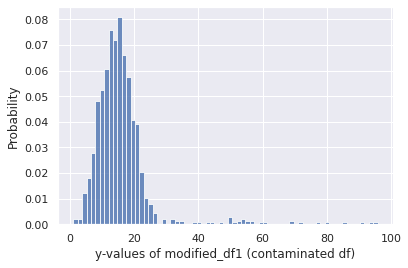

 1    950
-1     50
Name: is_outlier, dtype: int64


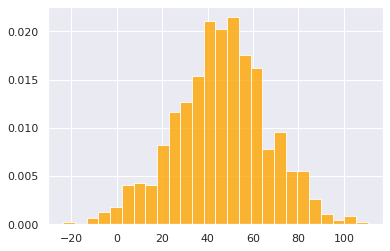

In [137]:

plt.xlabel('y-values of modified_df1 (contaminated df)')
plt.ylabel('Probability')
plt.hist(modified_df1['y1'], bins='auto', alpha=0.8, density = True, label='y1')
plt.show()
print(modified_df1_y["is_outlier"].value_counts())
plt.hist(test_df2['y1'], bins='auto', alpha=0.8, density = True, label='y1', color = 'orange')
plt.show()


In [ ]:
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

clf = IsolationForest(random_state=47, contamination = 0.05)

param_grid = {'n_estimators': list(range(30, 150, 5)),   
              'max_features': list(range(6,7)), 
              'bootstrap': [True, False], 
              'n_jobs': [-1]}


grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=scoring,
                                                 refit='Recall')

grid_dt_estimator.fit(X_train_modified, y_train_modified)

In [ ]:
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(modified_df1, modified_df1_y, test_size=0.2, random_state=11)

In [ ]:
plt.xlabel('y-values of modified_df1 (contaminated df)')
plt.ylabel('Probability')
plt.hist(modified_df1['y1'], bins='auto', alpha=0.8, density = True, label='y1')
plt.show()
print(modified_df1_y["is_outlier"].value_counts())
plt.hist(test_df2['y1'], bins='auto', alpha=0.8, density = True, label='y1')
plt.show()


In [ ]:
# Divide 10% of the dataset as the test set ; 90% of the dataset into a training set. 

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

# we don't really need y_test or y_train...

In [ ]:
# Instantiate model -> fit -> predict using test set.
# Note on contamination parameter: This is a parameter that the algorithm is quite sensitive to; it refers to the expected 
# proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples.

clf = IsolationForest(max_samples=0.5, contamination = 0, bootstrap = True )
clf.fit(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
pd.DataFrame(y_pred_test).value_counts()

1    10000
dtype: int64

The above says that only 2 of the 10k test set samples are found as outliers. Of course, these 2 are false-positives, since they are  generated by the formula of Friedman formula:


y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).

##Everything below is experimental:

In [ ]:
# Increasing features from 5->50? Only first 5 variables are correlated, so what if we add more independent variables. Would that change our predictions?
for i in range (5,10):
  X, y = make_friedman1(
    n_samples=100000, n_features = i,  noise=0.1, random_state=1)
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)
  clf = IsolationForest(max_samples='auto', contamination = 0)
  clf.fit(X_train)
  y_pred_test = clf.predict(X_test)
  print(i, pd.DataFrame(y_pred_test).value_counts())

In [ ]:
# Doesn't look like it!